<a href="https://colab.research.google.com/github/james-kidd/portfolio_anlaysis/blob/main/JameKidd_Report_CIGAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ETF Holdings Modeling — Public Data Case Study

This notebook demonstrates how public ETF holdings + ETF performance data can be used to train a simple model that estimates the probability that a stock appears among an ETF’s top holdings.

Focus on:


- Clean, reproducible data ingestion
- ETF-level and stock-level feature engineering
- Model transparency (Logistic Regression)
- Practical diagnostics
- Realistic limitations and expansion points




## Setup

In [ ]:
!pip install requests yfinance --quiet

import io
import requests
import pandas as pd
import numpy as np
import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
    log_loss,
)


# For reproducibility
RANDOM_STATE = 42


## Load ETF Universe

In [ ]:
# Select the range of the top K holdings.
TOP_K = 25

#Load ETF universe from iShares screener

ISHARES_SCREENER_URL = (
    "https://www.ishares.com/us/product-screener/product-screener-v3.jsn"
    "?dcrPath=/templatedata/config/product-screener-v3/data/en/us-ishares/product-screener-ketto"
)

resp = requests.get(ISHARES_SCREENER_URL)
raw = resp.json()

# Column names and data rows from the JSON
cols = [col["name"] for col in raw["data"]["tableData"]["columns"]]
rows = raw["data"]["tableData"]["data"]

df_funds = pd.DataFrame(
    [
        {
            col_name: (value[0] if isinstance(value, list) else value)
            for col_name, value in zip(cols, row)
        }
        for row in rows
    ],
    columns=cols,
)

# Optional: strip "aladdin", "esg", "nav", etc. prefixes from column names
prefixes = ["aladdin", "esg", "gls", "nav", "model", "investment"]

def strip_prefix(c: str) -> str:
    for p in prefixes:
        if c.lower().startswith(p.lower()):
            return c[len(p):]
    return c

df_funds.columns = df_funds.columns.map(strip_prefix)


# Filter equity ETFs with valid tickers
equity_etfs = df_funds[
    (df_funds["AssetClass"] == "Equity") &
    df_funds["localExchangeTicker"].notna()
]

# Sample universe
universe = equity_etfs.sample(30, random_state=RANDOM_STATE).reset_index(drop=True)
universe[["localExchangeTicker", "fundName"]].head()

# )

,localExchangeTicker,fundName
0,PFF,iShares Preferred and Income Securities ETF
1,IEZ,iShares U.S. Oil Equipment & Services ETF
2,IJJ,iShares S&P Mid-Cap 400 Value ETF
3,EUFN,iShares MSCI Europe Financials ETF
4,EWI,iShares MSCI Italy ETF


## Fetch Holdings

In [ ]:
# Download ETF holdings & label top-k

def holdings_url(row):
    url = row["productPageUrl"].rstrip("/")
    ticker = row["localExchangeTicker"]
    return (
        f"https://www.ishares.com{url}/1467271812596.ajax"
        f"?fileType=csv&fileName={ticker}_holdings&dataType=fund"
    )

def fetch_holdings_for_etf(row, top_k=TOP_K):
    ticker_etf = row["localExchangeTicker"]
    url = holdings_url(row)

    r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
    r.raise_for_status()
    lines = r.text.splitlines()

    header_idx = next(
        i for i, ln in enumerate(lines) if ln.startswith("Ticker,")
    )
    csv_text = "\n".join(lines[header_idx:])
    df = pd.read_csv(io.StringIO(csv_text))

    df = df.dropna(how="all")

    if "Asset Class" in df.columns:
        df = df[df["Asset Class"] == "Equity"]

    df = df.rename(columns={
        "Weight (%)": "weight_pct",
        "Sector": "sector",
        "Region": "region",
        "Market Value": "market_value",
    })

    if "Ticker" not in df.columns:
        return pd.DataFrame()

    # Sort by weight
    if "weight_pct" in df.columns:
        df["weight_pct"] = pd.to_numeric(df["weight_pct"], errors="coerce")
        df = df.sort_values("weight_pct", ascending=False)

    df["rank_in_etf"] = np.arange(1, len(df) + 1)
    df["in_top_k"] = (df["rank_in_etf"] <= top_k).astype(int)

    df["etf_ticker"] = ticker_etf
    df["etf_name"] = row["fundName"]

    return df.reset_index(drop=True)


# Fetch all holdings
all_holdings = []
for _, row in universe.iterrows():
    try:
        df_h = fetch_holdings_for_etf(row)
        all_holdings.append(df_h)
    except Exception as e:
        print("Error:", row["localExchangeTicker"], e)

holdings = pd.concat(all_holdings, ignore_index=True)
holdings.head()


Error: BRGKX 
Error: BSPAX 
Error: MASKX 


,Ticker,Name,sector,Asset Class,market_value,weight_pct,Notional Value,Quantity,Price,Location,...,Accrual Date,rank_in_etf,in_top_k,etf_ticker,etf_name,Type,Notional Weight,Market Weight,Strike price,Maturity
0,BA,BOEING CO,Industrial,Equity,"568,907,959.23",4.03,"568,907,959.23","8,991,749.00",63.27,United States,...,"Oct 31, 2024",1,1,PFF,iShares Preferred and Income Securities ETF,NaN,NaN,NaN,NaN,NaN
1,WFC,WELLS FARGO & COMPANY SERIES L,Financial Institutions,Equity,"339,146,798.80",2.41,"339,146,798.80","277,126.00","1,223.80",United States,...,"Apr 17, 2008",2,1,PFF,iShares Preferred and Income Securities ETF,NaN,NaN,NaN,NaN,NaN
2,C,CITIGROUP CAPITAL XIII,Financial Institutions,Equity,"210,453,241.04",1.49,"210,453,241.04","7,024,474.00",29.96,United States,...,"Oct 05, 2010",3,1,PFF,iShares Preferred and Income Securities ETF,NaN,NaN,NaN,NaN,NaN
3,MSTR,MICROSTRATEGY PERP STRETCH PRF SE,Industrial,Equity,"207,147,318.98",1.47,"207,147,318.98","2,190,181.00",94.58,United States,...,"Jul 29, 2025",4,1,PFF,iShares Preferred and Income Securities ETF,NaN,NaN,NaN,NaN,NaN
4,BAC,BANK OF AMERICA CORP,Financial Institutions,Equity,"193,385,936.80",1.37,"193,385,936.80","154,684.00","1,250.20",United States,...,"Jan 29, 2008",5,1,PFF,iShares Preferred and Income Securities ETF,NaN,NaN,NaN,NaN,NaN


In [ ]:
# # =========================================================
# # 3. Download ETF holdings and build holdings table
# # =========================================================

# def holdings_url(row) -> str:
#     """
#     Build the iShares CSV URL for a given ETF row.
#     """
#     url = row["productPageUrl"].rstrip("/")
#     ticker = row["localExchangeTicker"]
#     return (
#         f"https://www.ishares.com{url}/1467271812596.ajax"
#         f"?fileType=csv&fileName={ticker}_holdings&dataType=fund"
#     )


# def fetch_holdings_for_etf(row, top_k: int = TOP_K) -> pd.DataFrame:
#     """
#     Fetch holdings for a single ETF and create labels for top_k holdings.
#     """
#     ticker_etf = row["localExchangeTicker"]
#     url = holdings_url(row)

#     r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
#     r.raise_for_status()
#     lines = r.text.splitlines()

#     # Find header row that starts with "Ticker"
#     header_idx = next(
#         i for i, ln in enumerate(lines) if ln.startswith("Ticker,")
#     )
#     csv_text = "\n".join(lines[header_idx:])
#     df = pd.read_csv(io.StringIO(csv_text))

#     # Basic cleaning
#     df = df.dropna(how="all")

#     # Keep only equities when available
#     if "Asset Class" in df.columns:
#         df = df[df["Asset Class"] == "Equity"]

#     # Standardize key column names
#     df = df.rename(
#         columns={
#             "Weight (%)": "weight_pct",
#             "Sector": "sector",
#             "Region": "region",
#             "Market Value": "market_value",
#         }
#     )

#     if "Ticker" not in df.columns:
#         raise ValueError(f"No 'Ticker' column for ETF {ticker_etf}")

#     # Rank holdings by weight (or market value if needed)
#     if "weight_pct" in df.columns:
#         df = df.sort_values("weight_pct", ascending=False)
#     elif "market_value" in df.columns:
#         df = df.sort_values("market_value", ascending=False)

#     df["rank_in_etf"] = np.arange(1, len(df) + 1)
#     df["in_top_k"] = (df["rank_in_etf"] <= top_k).astype(int)

#     # Attach ETF-level identity
#     df["etf_ticker"] = ticker_etf
#     df["etf_name"] = row["fundName"]

#     return df.reset_index(drop=True)


# # Loop over the ETF universe and aggregate all holdings
# all_holdings = []

# for _, row in universe.iterrows():
#     try:
#         h = fetch_holdings_for_etf(row, top_k=TOP_K)
#         all_holdings.append(h)
#     except Exception as e:
#         print(f"Failed to fetch holdings for {row['localExchangeTicker']}: {e}")

# holdings = pd.concat(all_holdings, ignore_index=True)
# holdings.head()


## ETF Performance

In [ ]:

def etf_features_yf(etf_ticker, lookback="3y"):
    data = yf.download(etf_ticker, period=lookback, auto_adjust=True)
    if data.empty:
        return None

    close = data["Close"]
    if isinstance(close, pd.DataFrame):
        close = close.iloc[:, 0]

    returns = close.pct_change().dropna()
    if returns.empty:
        return None

    daily_mean = float(returns.mean())
    daily_std = float(returns.std())

    ann_return = (1 + daily_mean)**252 - 1
    ann_vol = daily_std * np.sqrt(252)
    sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan

    return {
        "etf_ticker": etf_ticker,
        "etf_ann_return": ann_return,
        "etf_ann_vol": ann_vol,
        "etf_sharpe": sharpe,
    }

# Build ETF feature table
etf_list = holdings["etf_ticker"].unique().tolist()
etf_features = pd.DataFrame(
    [feats for t in etf_list if (feats := etf_features_yf(t))]
)

etf_features.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,etf_ticker,etf_ann_return,etf_ann_vol,etf_sharpe
0,PFF,0.063119,0.100811,0.626112
1,IEZ,0.056117,0.323905,0.173251
2,IJJ,0.104941,0.188442,0.556889
3,EUFN,0.336390,0.183359,1.834604
4,EWI,0.307405,0.181048,1.697922


## Build Modeling Dataset

In [ ]:
# =========================================================
# Build modeling dataset
# =========================================================

data = holdings.merge(etf_features, on="etf_ticker", how="inner")

# Stock-level numeric features
data["weight_pct"] = pd.to_numeric(data["weight_pct"], errors="coerce")
data["weight_share"] = (
    data.groupby("etf_ticker")["weight_pct"]
        .transform(lambda s: s / s.sum() if s.sum() > 0 else np.nan)
)

data["log_weight_pct"] = np.log(data["weight_pct"].replace(0, np.nan))

# Stock-level categorical
data["sector"] = data["sector"].fillna("Unknown")

# Remove unused, unreliable features
# log_market_value completeness is < 1%
# data["log_market_value"] = ...

data = data[data["in_top_k"].notna()].copy()
data["in_top_k"] = data["in_top_k"].astype(int)

len(data)


8630

## Feature Completeness Report

We generate a full null/non-null report for:

- ETF-level features
- Stock-level numeric features
- Stock-level categorical features



This supports data quality assessment and explains why missingness is imputed in the model pipeline.

In [ ]:
# SIMPLE FEATURE COMPLETENESS REPORT (LEVEL + TYPE)

etf_numeric = ["etf_ann_return", "etf_ann_vol", "etf_sharpe"]
stock_numeric = [ "weight_share",]
etf_categorical = []
stock_categorical = ["sector"]

all_features = etf_numeric + stock_numeric + stock_categorical

rows = []

for col in all_features:
    total = len(data)
    null = data[col].isna().sum()
    non_null = total - null

    # Determine Level (ETF-level or Stock-level)
    if col in etf_numeric or col in etf_categorical:
        level = "ETF-level"
    else:
        level = "Stock-level"

    # Determine Type (numeric or categorical)
    if col in etf_numeric or col in stock_numeric:
        ftype = "numeric"
    else:
        ftype = "categorical"

    rows.append({
        "Feature": col,
        "Level": level,
        "Type": ftype,
        "Non-null": non_null,
        "Null": null,
        "Completeness %": round(non_null / total * 100, 2)
    })

simple_feature_report = pd.DataFrame(rows)
simple_feature_report


,Feature,Level,Type,Non-null,Null,Completeness %
0,etf_ann_return,ETF-level,numeric,8630,0,100.00
1,etf_ann_vol,ETF-level,numeric,8630,0,100.00
2,etf_sharpe,ETF-level,numeric,8630,0,100.00
3,weight_share,Stock-level,numeric,8087,543,93.71
4,sector,Stock-level,categorical,8630,0,100.00


## Feature selection

In [ ]:
# Feature selection and train/test split


# Numeric ETF-level + numeric stock-level features
feature_cols_num = [
    "etf_ann_return",
    "etf_ann_vol",
    "etf_sharpe",
]

feature_cols_cat = ["sector"]  # region can be added later if needed

target_feature = "in_top_k"

# Ensure sector has no missing values
data["sector"] = data["sector"].fillna("Unknown")

X = data[feature_cols_num + feature_cols_cat]
y = data[target_feature].values

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y,
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

print("Y_train shape:", y_train.shape)
print("Y_test shape:", y_test.shape)




X_train shape: (6904, 4)
X_test shape: (1726, 4)
Y_train shape: (6904,)
Y_test shape: (1726,)


## Modeling

In [ ]:
# Modeling pipeline: Logistic Regression


numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("oh", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, feature_cols_num),
        ("cat", categorical_transformer, feature_cols_cat),
    ]
)

clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", LogisticRegression(
            max_iter=500,
            class_weight="balanced",  # handle class imbalance
        )),
    ]
)

clf.fit(X_train, y_train)

print("Train accuracy:", clf.score(X_train, y_train))
print("Test accuracy :", clf.score(X_test, y_test))


Train accuracy: 0.7197276940903824
Test accuracy : 0.7184241019698725


Evaluation Metrics
- ROC-AUC
- Log Loss
- Confusion matrix
- Precision/recall




In [ ]:
# Probabilities for ROC-AUC and log loss
y_prob = clf.predict_proba(X_test)[:, 1]
y_pred = clf.predict(X_test)

In [130]:
# Evaluation metrics

auc = roc_auc_score(y_test, y_prob)
ll = log_loss(y_test, y_prob)

print("ROC-AUC:", auc)
print("Log Loss:", ll)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


ROC-AUC: 0.7633183342798755
Log Loss: 0.5637469595235369

Confusion Matrix:
[[1157  440]
 [  46   83]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9618    0.7245    0.8264      1597
           1     0.1587    0.6434    0.2546       129

    accuracy                         0.7184      1726
   macro avg     0.5602    0.6839    0.5405      1726
weighted avg     0.9017    0.7184    0.7837      1726



Visualization of Evaluation Metrics

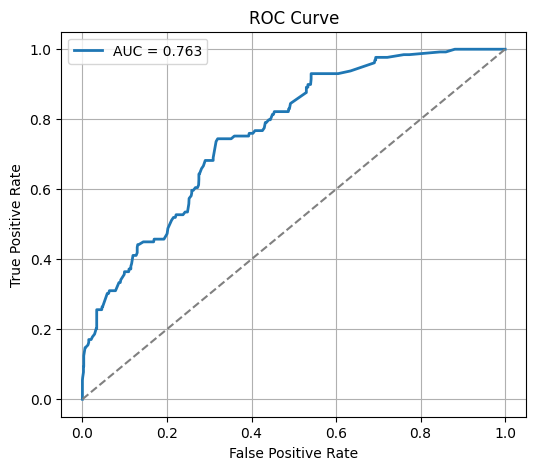

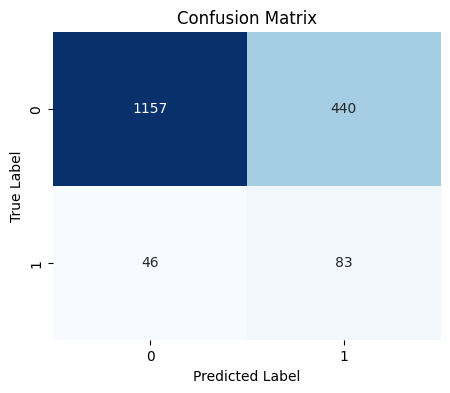

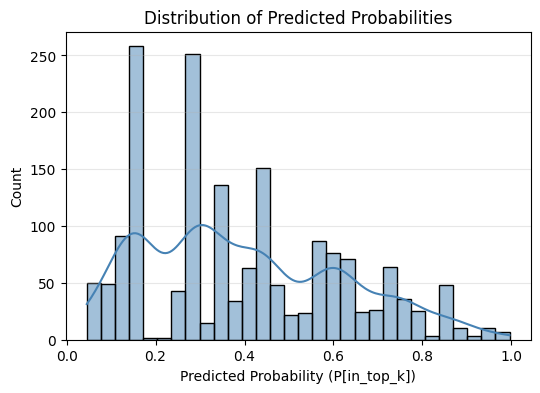

In [131]:
# Visualization of Evaluation Metrics

from sklearn.metrics import precision_score, recall_score

# ROC Curve

fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", linewidth=2)
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# Predicted Probability Distribution
plt.figure(figsize=(6,4))
sns.histplot(y_prob, bins=30, kde=True, color="steelblue")
plt.xlabel("Predicted Probability (P[in_top_k])")
plt.ylabel("Count")
plt.title("Distribution of Predicted Probabilities")
plt.grid(axis="y", alpha=0.3)
plt.show()




In [133]:
# ETF-level prediction helper

def probs_for_etf(etf_ticker: str, df_all: pd.DataFrame = data, model=clf) -> pd.DataFrame | None:
    """
    For a given ETF ticker, compute the predicted probability that each holding
    is in the top-k group, using the trained model.
    """
    df_etf = df_all[df_all["etf_ticker"] == etf_ticker].copy()
    if df_etf.empty:
        print(f"No rows found for ETF: {etf_ticker}")
        return None

    needed = feature_cols_num + feature_cols_cat
    missing = [c for c in needed if c not in df_etf.columns]
    if missing:
        print(f"Missing columns for ETF {etf_ticker}: {missing}")
        return None

    # Let the pipeline handle missing values; no need to drop rows here,
    # but can drop rows where *all* features are NA, if any.
    if df_etf[needed].isna().all(axis=1).any():
        df_etf = df_etf[~df_etf[needed].isna().all(axis=1)]

    X_etf = df_etf[needed]
    df_etf["p_in_top_k"] = model.predict_proba(X_etf)[:, 1]

    return df_etf.sort_values("p_in_top_k", ascending=False)


In [136]:
# Example ETF Prediction (Ranked & Visualized)

# First ETF in sample universe
example_etf = universe.iloc[0]["localExchangeTicker"]
example_results = probs_for_etf(example_etf)
example_etf_name = universe[universe["localExchangeTicker"] == example_etf]["fundName"].values[0]

if example_results is None:
    print("No results for ETF:", example_etf)
else:
    # Sort by actual weight_pct (highest to lowest)
    example_results = example_results.sort_values("weight_pct", ascending=False)

    # Reset index to create rank index (1 = largest weight)
    example_results = example_results.reset_index(drop=True)
    example_results.index = example_results.index + 1   # start rank at 1
    example_results.index.name = "Rank"

    # Display top 15 cleanly
    print(f"\nTop Holdings — {example_etf_name} ({example_etf})\n")
    display(example_results[["Ticker", "sector", "p_in_top_k"]].head(5))




Top Holdings — iShares Preferred and Income Securities ETF (PFF)



,Ticker,sector,p_in_top_k
Rank,,,
1,BA,Industrial,0.557628
2,WFC,Financial Institutions,0.337572
3,C,Financial Institutions,0.337572
4,MSTR,Industrial,0.557628
5,KKR,Financial Institutions,0.337572
